In [1622]:
import numpy as np

from probts.data.data_utils.data_scaler import Scaler, StandardScaler, IdentityScaler, TemporalScaler

from probts.model.forecaster import LinearForecaster, NaiveForecaster
from probts.model.forecast_module import ProbTSForecastModule
from probts.data import ProbTSDataModule, DataManager, ProbTSBatchData
from probts.utils import find_best_epoch
from lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

In [1623]:
class BinaryQuantizer(Scaler):
    def __init__(self, num_bins=200, min_val=-10.0, max_val=10.0):
        super().__init__()
        self.num_bins = num_bins
        self.min_val = min_val
        self.max_val = max_val
        self.bin_values_ = torch.linspace(self.min_val, self.max_val, self.num_bins)

    def fit(self, values):
        self.min_val = values.min()
        self.max_val = values.max()
        self.bin_values_ = torch.linspace(self.min_val, self.max_val, self.num_bins)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

    def transform(self, values):
        bin_thresholds = self.bin_values_.reshape(1, 1, -1)
        return (values >= bin_thresholds).float()

    def inverse_transform(self, values):
        reversed_bin = torch.flip(values, dims=(-1,))
        idx_first_one_reversed = reversed_bin.argmax(axis=-1)[..., None]
        idx_last_one = self.num_bins - 1 - idx_first_one_reversed
        reconstructed = self.bin_values_[idx_last_one]
        return reconstructed

In [1624]:
class StandardBinScaler(Scaler):
    def __init__(self, standard: StandardScaler, bin: BinaryQuantizer):
        super().__init__()
        self.standard = standard
        self.bin = bin

    def fit(self, X):
        Z = self.standard.fit_transform(X)
        self.bin.fit(Z)
        print('the scaler was fitted')

    def transform(self, X):
        Z = self.standard.transform(X)
        return self.bin.transform(Z)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        Z = self.bin.inverse_transform(X)
        return self.standard.inverse_transform(Z)

In [1625]:
# data_manager = DataManager(
#     dataset='tourism_monthly',
#     path='../datasets',
#     context_length=12,
#     prediction_length=12,
# )
# data_manager.context_length

In [1626]:
class CustomDataManager(DataManager):
    def _configure_scaler(self, scaler_type: str):
        """Configure the scaler."""
        if scaler_type == "standard":
            return StandardScaler(var_specific=self.var_specific_norm)
        elif scaler_type == "temporal":
            return TemporalScaler()
        elif scaler_type == "binary":
            return BinaryQuantizer()
        elif scaler_type == "standard_binary":
            # return StandardBinScaler(StandardScaler(var_specific=self.var_specific_norm), BinaryQuantizer())
            return StandardBinScaler(TemporalScaler(), BinaryQuantizer())
        return IdentityScaler()

In [1627]:
# data_module = ProbTSDataModule(
#     data_manager=data_manager,
#     batch_size=32,
#     test_batch_size=32,
#     num_workers=8,
# )
# test_dataloader = data_module.test_dataloader()
# train_dataloader = data_module.train_dataloader()
# val_dataloader = data_module.val_dataloader()

In [1628]:
# for test_batch in test_dataloader:
#     break

In [1629]:
# batch_data = ProbTSBatchData(test_batch, 'cpu')
# batch_data.past_target_cdf.shape

In [1630]:
# plt.figure(figsize=(10,3))
# plt.plot(batch_data.past_target_cdf[13, :, 0].t())
# plt.show()

In [1631]:
# scaler = StandardBinScaler(StandardScaler(), BinaryQuantizer())
# scaler.fit(batch_data.past_target_cdf)
# transformed = scaler.transform(batch_data.past_target_cdf)
# transformed.shape

In [1632]:
# plt.figure(figsize=(10,3))
# plt.imshow(transformed[13].T, aspect='auto', interpolation='none', cmap='Reds')
# plt.show()

In [1633]:
# reconstructed = scaler.inverse_transform(transformed)
# reconstructed.shape

In [1634]:
# plt.figure(figsize=(10,3))
# plt.plot(reconstructed[13, :, 0].t())
# plt.show()


In [1635]:
data_manager = CustomDataManager(
    dataset='tourism_monthly',
    # dataset='m4_daily',
    path='../datasets',
    context_length=72,
    prediction_length=24,
    # scaler="standard_binary",
    scaler="identity",
)

# data_manager = DataManager(
#     dataset='m4_daily',
#     # dataset='etth1',
#     path='./datasets',
#     context_length=12,
#     prediction_length=12,
#     scaler="standard_binary",
# )

Loading Short-term Dataset: tourism_monthly



Download tourism_monthly_dataset.zip:: 200kB [00:00, 463kB/s]

creating json files: 100%|██████████| 366/366 [00:00<00:00, 361714.25it/s]

No validation set is used.


In [1636]:
# data_manager.dataset_raw.training_dataset

In [1637]:
data_manager.context_length

72

In [1638]:
data_module = ProbTSDataModule(
    data_manager=data_manager,
    batch_size=1,
    test_batch_size=1,
    num_workers=8,
)
test_dataloader = data_module.test_dataloader()
train_dataloader = data_module.train_dataloader()
val_dataloader = data_module.val_dataloader()

In [1639]:
for test_batch in test_dataloader:
    break

In [1640]:
test_batch['past_target_cdf'].shape

torch.Size([1, 84])

In [1641]:
test_batch['past_target_cdf'].reshape(-1, 1).shape

torch.Size([84, 1])

In [1642]:
# data_manager.scaler.standard.mean

In [1643]:
data_manager.scaler.transform(test_batch['past_target_cdf'].reshape(-1, 1))

tensor([[5466.7803],
        [3235.1677],
        [2157.9800],
        [1379.7252],
        [1728.0400],
        [1350.1099],
        [1216.0149],
        [1751.3252],
        [1805.3201],
        [2570.0249],
        [3204.2402],
        [5395.7202],
        [6078.8286],
        [3587.0984],
        [2285.1951],
        [1582.1899],
        [1787.4298],
        [1554.8701],
        [1409.8649],
        [1612.1250],
        [2286.2400],
        [2913.7551],
        [3645.9084],
        [5956.7085],
        [6326.9751],
        [3914.6602],
        [2617.6750],
        [1675.1650],
        [2139.2200],
        [1715.4899],
        [1663.5800],
        [2053.7000],
        [2354.9299],
        [3038.5918],
        [3470.6094],
        [6606.1836],
        [6587.6367],
        [4133.7827],
        [2960.0244],
        [1762.5850],
        [2125.6401],
        [1815.9150],
        [1632.3149],
        [2210.3950],
        [2210.2151],
        [3099.2693],
        [3468.7778],
        [6482

In [1644]:
# for train_batch in train_dataloader:
#     break

In [1645]:
# batch_data = ProbTSBatchData(test_batch, 'cpu')
# batch_data.past_target_cdf.shape

In [1646]:
data_manager.context_length

72

In [1647]:
def sliding_window_batch(x, L, H):
    """
    x: Tensor of shape (B, L+H, C)
    Returns: Tensor of shape (B, H, L, C)
    """
    B, total_len, C = x.shape
    assert total_len >= L + H, "Not enough sequence length for given L and H"

    windows = [x[:, h:h + L, :].unsqueeze(1) for h in range(H)]  # list of (B, 1, L, C)
    return torch.cat(windows, dim=1)  # (B, H, L, C)

In [1648]:
### h = 2, L =5
### total: 7
### target indexes: 5,6
## h=0 - 0:5 [0,1,2,3,4]
## h=1 - 1:6 [1,2,3,4,5]

In [1816]:
# def most_probable_monotonic_sequence(p: torch.Tensor):
#     """
#     p: Tensor of shape (B, D) where each row is a probability vector
#     Returns:
#         best_sequences: Tensor of shape (B, D) with most probable [1...1, 0...0] sequence per batch
#         best_probs: Tensor of shape (B,) with normalized probability of each best sequence
#     """
#     B, D = p.shape
#
#     # Compute cumulative product of p and (1 - p)
#     left_cumprod = torch.cumprod(p, dim=1)  # shape (B, D)
#     right_cumprod = torch.cumprod((1 - p).flip(dims=[1]), dim=1).flip(dims=[1])  # shape (B, D)
#     print(left_cumprod)
#     print(right_cumprod)
#     # Pad left with 1 at the beginning (per batch)
#     ones = torch.ones((B, 1), dtype=p.dtype, device=p.device)
#     left = torch.cat([ones, left_cumprod[:, :-1]], dim=1)  # shape (B, D)
#     right = right_cumprod  # shape (B, D)
#
#     # Element-wise multiply
#     probs = left * right  # shape (B, D)
#
#     # Normalize
#     probs_sum = probs.sum(dim=1, keepdim=True)  # shape (B, 1)
#     probs_normalized = probs / probs_sum
#
#     # Find best cut index per batch
#     best_k = torch.argmax(probs_normalized, dim=1)  # shape (B,)
#
#     # Construct best sequences
#     arange = torch.arange(D, device=p.device).unsqueeze(0)  # shape (1, D)
#     best_k_expanded = best_k.unsqueeze(1)  # shape (B, 1)
#     best_sequences = (arange < best_k_expanded).to(p.dtype)  # shape (B, D)
#     print(probs_normalized.shape)
#     print(best_k.unsqueeze(1).shape)
#     # Get best normalized probabilities
#     best_probs = torch.gather(probs_normalized, dim=1, index=best_k.unsqueeze(1)).squeeze(1)  # shape (B,)
#
#     return best_sequences, best_probs

def most_probable_monotonic_sequence(p: torch.Tensor, is_sample:bool):
    """
    p: Tensor of shape (B, D) where each row is a probability vector
    Returns:
        best_sequences: Tensor of shape (B, D) with most probable [1...1, 0...0] sequence per batch
        best_probs: Tensor of shape (B,) with normalized probability of each best sequence
    """
    B, D = p.shape

    # Compute cumulative product of p and (1 - p)
    success_cumprod = torch.cumprod(p, dim=1)  # shape (B, D)
    fail_cumprod = torch.cumprod((1 - p).flip(dims=[1]), dim=1).flip(dims=[1])  # shape (B, D)

    # Pad left with 1 at the beginning (per batch)
    ones = torch.ones((B, 1), dtype=p.dtype, device=p.device)
    success = torch.cat([ones, success_cumprod], dim=1)  # shape (B, D)
    fail = torch.cat([fail_cumprod, ones], dim=1)  # shape (B, D)
    # Element-wise multiply
    probs = success * fail  # shape (B, D)
    # Normalize
    probs_sum = probs.sum(dim=1, keepdim=True)  # shape (B, 1)
    probs_normalized = probs / probs_sum

    # Find best cut index per batch
    if is_sample:
        k = torch.multinomial(probs_normalized, num_samples=1)  # shape (B, 1)
    else:
        k = torch.argmax(probs_normalized, dim=1).unsqueeze(1)  # shape (B,1)

    # Construct best sequences
    arange = torch.arange(D, device=p.device).unsqueeze(0)  # shape (1, D)
    best_sequences = (arange < k).to(p.dtype)  # shape (B, D)
    # Get best or sampled normalized probabilities

    best_probs = torch.gather(probs_normalized, dim=1, index=k).squeeze(1)  # shape (B,)

    return best_sequences, best_probs

In [1815]:
most_probable_monotonic_sequence(torch.tensor([0.51, 0.51]).reshape(1,-1), False)

tensor([[0.2401, 0.2499, 0.2601]])
torch.Size([1, 1])
torch.Size([1, 3])
torch.Size([1, 1, 1])


(tensor([[1., 1.]]), tensor([0.3468]))

In [1787]:
0.2
0.2*0.9

0.18000000000000002

In [1738]:
torch.arange(10).unsqueeze(0)

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [1739]:
0.8*0.9 # 10

0.7200000000000001

In [1740]:
0.2*0.9 #00

0.18000000000000002

In [1741]:
0.8*0.1 #11

0.08000000000000002

In [1742]:
0.72/(0.72+0.08+0.18)

0.7346938775510204

In [1650]:
class DynamicTanh(nn.Module):
    def __init__(self, normalized_shape, channels_last, alpha_init_value=0.5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.alpha_init_value = alpha_init_value
        self.channels_last = channels_last

        self.alpha = nn.Parameter(torch.ones(1) * alpha_init_value)
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        x = torch.tanh(self.alpha * x)
        if self.channels_last:
            x = x * self.weight + self.bias
        else:
            # x = x * self.weight[:, None, None] + self.bias[:, None, None]
            x = x * self.weight[:, None] + self.bias[:, None]
        return x

    def extra_repr(self):
        return f"normalized_shape={self.normalized_shape}, alpha_init_value={self.alpha_init_value}, channels_last={self.channels_last}"


In [1651]:
from probts.model.forecaster import Forecaster
from torch import nn
import torch.nn.functional as F


class BinConv(Forecaster):
    def __init__(self, context_length: int, num_bins: int, kernel_size_across_bins_2d: int = 3,
                 kernel_size_across_bins_1d: int = 3, num_filters_2d: int = 8,
                 num_filters_1d: int = 32, is_cum_sum: bool = False, num_1d_layers: int = 2, num_blocks: int = 3,
                 kernel_size_ffn: int = 51,
                 **kwargs) -> None:
        """
        Initialize the model with parameters.
        """
        super().__init__(context_length=context_length, **kwargs)
        # Initialize model parameters here
        self.context_length = context_length
        self.num_bins = num_bins
        self.num_filters_2d = num_filters_2d
        self.num_filters_1d = num_filters_1d
        self.kernel_size_across_bins_2d = kernel_size_across_bins_2d
        self.kernel_size_across_bins_1d = kernel_size_across_bins_1d
        self.is_cum_sum = is_cum_sum
        self.scaler = StandardBinScaler(StandardScaler(var_specific=True), BinaryQuantizer())
        self.num_1d_layers = num_1d_layers
        self.num_blocks = num_blocks
        self.kernel_size_ffn = kernel_size_ffn
        self.dropout = nn.Dropout(0.2)

        # Conv2d over (context_length, num_bins)

        self.conv2d = nn.ModuleList([nn.Conv2d(
            in_channels=1,
            out_channels=self.num_filters_2d,
            # kernel_size=(context_length if i == 0 else kernel_size_across_bins_2d, kernel_size_across_bins_2d),
            kernel_size=(context_length, kernel_size_across_bins_2d),
            bias=True
        ) for _ in range(num_blocks)
        ])
        self.conv1d = nn.ModuleList([
            nn.ModuleList([
                nn.Conv1d(in_channels=num_filters_2d if i == 0 else num_filters_1d,
                          out_channels=context_length if i == num_1d_layers - 1 else num_filters_1d,
                          kernel_size=kernel_size_across_bins_1d, bias=True,
                          groups=num_filters_1d)
                          # groups=1)
                for i in range(num_1d_layers)
            ]) for _ in range(num_blocks)
        ])
        self.conv_ffn = nn.Conv1d(
            # in_channels=self.num_filters_1d,
            in_channels=context_length,
            out_channels=1,
            kernel_size=kernel_size_ffn,  # large kernel size?
            groups=1,
            bias=True
        )
        print('conv 1d:')
        print(self.conv1d)
        assert num_filters_2d == num_filters_1d, "todo: change the self.act shape if not"
        self.act = nn.ModuleList([
            nn.ModuleList([
                # DynamicTanh(normalized_shape=num_filters_2d if i == 0 else num_filters_1d, channels_last=False)
                DynamicTanh(normalized_shape=num_filters_2d if i < self.num_1d_layers else context_length,
                            channels_last=False)
                for i in range(self.num_1d_layers + 1)  # applied after conv2d, and all conv1d including the last one
            ]) for _ in range(self.num_blocks)
        ])
        # self.conv_ffn = nn.Sequential(
        #     nn.Conv1d(1, num_bins, kernel_size=1),
        #     nn.ReLU(),
        #     nn.Conv1d(num_bins, num_bins, kernel_size=1),
        #     # nn.Dropout(dropout)
        # )

        #
        # self.conv1d_1 = nn.Conv1d(
        #     in_channels=self.num_filters_2d,
        #     out_channels=self.num_filters_1d,
        #     kernel_size=kernel_size_across_bins_1d,
        #     # groups=self.num_filters_1d,
        #     bias=True
        # )
        #
        # self.conv1d_2 = nn.Conv1d(
        #     in_channels=self.num_filters_1d,
        #     out_channels=1,
        #     kernel_size=kernel_size_across_bins_1d,
        #     bias=True
        # )
        #
        # self.dyt_2d = DynamicTanh(normalized_shape=num_filters_2d, channels_last=False)
        # self.dyt_1d = DynamicTanh(normalized_shape=num_filters_1d, channels_last=False)

    def _pad_channels(self, tensor: torch.Tensor, pad_size: int, pad_val_left=1.0, pad_val_right=0.0):
        if pad_size == 0:
            return tensor
        left = torch.full((*tensor.shape[:-1], pad_size), pad_val_left, device=tensor.device)
        right = torch.full((*tensor.shape[:-1], pad_size), pad_val_right, device=tensor.device)
        return torch.cat([left, tensor, right], dim=-1)

    def conv_layer(self, x: torch.Tensor, conv_func, act_func, kernel_size: int, is_2d: bool, ):
        # kernel_size = self.kernel_size_across_bins_2d if is_2d else self.kernel_size_across_bins_1d
        pad = kernel_size // 2 if kernel_size > 1 else 0
        x_padded = self._pad_channels(x, pad)
        if is_2d:
            x_padded = x_padded.unsqueeze(1)
        conv_out = conv_func(x_padded)  # (batch_size, num_filters_2d, num_bins)
        # print(f'conv out shape:{conv_out.shape}')
        if is_2d:
            conv_out = conv_out.squeeze(2)
        if act_func is not None:
            conv_out = act_func(conv_out)
        return conv_out

    def forward(self, x):

        x = x.float()
        # x: (batch_size, context_length, num_bins)
        batch_size, context_length, num_bins = x.shape
        assert context_length == self.context_length, "Mismatch in context length"

        for j in range(self.num_blocks):

            residual = x
            x = self.conv_layer(x, self.conv2d[j], self.act[j][0], self.kernel_size_across_bins_2d, True)
            for i in range(self.num_1d_layers):
                # x = self.conv_layer(x, self.conv1d[j][i], self.act[j][i + 1], False)
                x = self.conv_layer(x, self.conv1d[j][i], F.relu,
                                    self.kernel_size_across_bins_1d, False)
            x = self.dropout(x)
            x = x + residual

            # x = self.conv_layer(x, self.conv2d, self.dyt_2d, True)  # (batch_size, num_filters_2d, num_bins)
            # x = self.conv_layer(x, self.conv1d_1, self.dyt_1d, False)
            # x = self.conv_layer(x, self.conv1d_2, None, False) # (batch_size, num_bins)
            # print('x shape')
            # print(x.squeeze(1).shape)

        out = self.conv_layer(x, self.conv_ffn, None, self.kernel_size_ffn, False).squeeze(1)
        # out = self.conv_ffn(x.squeeze(1))

        if self.is_cum_sum:
            assert False
            out = torch.flip(torch.cumsum(torch.flip(out, dims=[1]), dim=1), dims=[1])
        return out

    def loss(self, batch_data):
        """
        Compute the loss for the given batch data.

        Parameters:
        batch_data [dict]: Dictionary containing input data and possibly target data.

        Returns:
        Tensor: Computed loss.
        """
        # Extract inputs and targets from batch_data
        inputs = self.get_inputs(batch_data, 'all')
        orig_target = inputs[:, -self.prediction_length:, :]
        # print(f'inputs shape:{inputs.shape}')
        # print(f'scale shape:{inputs.reshape(-1)[:-self.prediction_length].shape}')
        self.scaler.fit(inputs.reshape(-1)[:-self.prediction_length])
        inputs = self.scaler.transform(inputs)
        print('inputs transformed')
        print(inputs.shape)
        print(inputs.sum(dim=-1))
        target = inputs[:, -self.prediction_length:, :]
        # print(f'bool:{torch.allclose(inputs[:, -self.prediction_length:, :], batch_data.future_target_cdf.float())}')
        inputs = sliding_window_batch(inputs, self.context_length, self.prediction_length).float()
        outputs = self(inputs.view(-1, *inputs.shape[2:]))
        print(f'outputs transformed:')
        print(outputs.shape)
        with torch.no_grad():
            pred = F.sigmoid(outputs)
            print('seq')
            print(pred.sum(dim=-1))
            # pred, _ = most_probable_monotonic_sequence(pred)
            pred = (pred >= 0.5).int()
            print('out:')
            pred = self.scaler.inverse_transform(pred).reshape(-1)
            target_inv = self.scaler.inverse_transform(target).reshape(-1)
            print(pred)
            print(target_inv)
            print(orig_target.reshape(-1))
            # plt.plot(pred, color='red')
            # plt.plot(target_inv)
            plt.show()
        # outputs = outputs[:, -self.prediction_length-1:-1, ...]
        # target = batch_data.future_target_cdf.float()

        loss = F.binary_cross_entropy_with_logits(input=outputs, target=target.view(-1, *target.shape[2:]), )
        print(loss)
        return loss

    def forecast(self, batch_data, num_samples=None):
        inputs = self.get_inputs(batch_data, 'encode')

        self.scaler.fit(inputs.reshape(-1))
        inputs = self.scaler.transform(inputs)
        print('inputs:')
        print(inputs.shape)
        print(inputs.sum(dim=-1))
        current_context = inputs.clone()
        forecasts = []
        for _ in range(self.prediction_length):
            pred = F.sigmoid(self(current_context))  # (B, D)
            # pred = (pred >= 0.5).int()
            pred, _ = most_probable_monotonic_sequence(pred)
            pred = pred.int()
            forecasts.append(pred.unsqueeze(1))  # (B, 1, D)
            next_input = pred.unsqueeze(1)
            current_context = torch.cat([current_context[:, 1:], next_input], dim=1)

        forecasts = torch.cat(forecasts, dim=1)
        print(forecasts.shape)
        print(f'forecast : {forecasts.sum(dim=-1)}')
        forecasts = self.scaler.inverse_transform(forecasts)
        # print(f'post forecast shape:{forecasts.shape}')
        # return forecasts  # (B, T, D)
        return forecasts.unsqueeze(0)

    # def forecast(self, batch_data, num_samples=None):
    #     """
    #     Generate forecasts for the given batch data.
    #
    #     Parameters:
    #     batch_data [dict]: Dictionary containing input data.
    #     num_samples [int, optional]: Number of samples per distribution during evaluation. Defaults to None.
    #
    #     Returns:
    #     Tensor: Forecasted outputs.
    #     """
    #     # Perform the forward pass to get the outputs
    #     outputs = self(batch_data.past_target_cdf[:, -self.context_length:, :])
    #     print(f'num samples:{num_samples}')
    #     if num_samples is not None:
    #         # If num_samples is specified, use it to sample from the distribution
    #         outputs = self.sample_from_distribution(outputs, num_samples)
    #     else:
    #         # If perform point estimation, the num_samples is equal to 1
    #         outputs = outputs.unsqueeze(1)
    #     return outputs  # [batch_size, num_samples, prediction_length, var_num]

In [1652]:
data_manager.context_length

72

In [1653]:
forecaster = BinConv(
    num_bins=200,
    kernel_size_across_bins_2d=7,
    kernel_size_across_bins_1d=11,
    num_filters_2d=72 // 2,
    num_filters_1d=72 // 2,
    kernel_size_ffn= 200//4 + 1,
    num_1d_layers=2,
    num_blocks=3,
    use_lags=False,
    use_feat_idx_emb=False,
    use_time_feat=False,
    target_dim=data_manager.target_dim,
    context_length=data_manager.context_length,
    prediction_length=data_manager.prediction_length,
    freq=data_manager.freq,
    lags_list=data_manager.lags_list,
    time_feat_dim=data_manager.time_feat_dim,
    dataset=data_manager.dataset,
)
model = ProbTSForecastModule(
    forecaster=forecaster,
    scaler=data_manager.scaler,
    learning_rate=0.001,
    quantiles_num=20,
    num_samples=1
)

conv 1d:
ModuleList(
  (0-2): 3 x ModuleList(
    (0): Conv1d(36, 36, kernel_size=(11,), stride=(1,), groups=36)
    (1): Conv1d(36, 72, kernel_size=(11,), stride=(1,), groups=36)
  )
)
sampling_weight_scheme: none


/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'forecaster' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forecaster'])`.


In [1654]:
trainer = Trainer(
    accelerator="cpu",
    devices=1,
    strategy="auto",
    max_epochs=5,
    use_distributed_sampler=False,
    limit_train_batches=100,
    log_every_n_steps=1,
    accumulate_grad_batches=8,
    default_root_dir='./results',
    logger=CSVLogger('./logs'),
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [1655]:
target = []
for data in list(data_manager.dataset_raw.train):
    target.append(data['target'])

In [1656]:
# import numpy as np
# model.scaler.fit(torch.tensor(np.concatenate(target)).reshape(-1))

In [1657]:
# model.scaler.standard.mean

In [1658]:
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | forecaster | BinConv | 63.0 K | train
-----------------------------------------------
63.0 K    Trainable params
0         Non-trainable params
63.0 K    Total params
0.252     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:106: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Training: |          | 0/? [00:00<?, ?it/s]

the scaler was fitted
inputs transformed
torch.Size([1, 96, 200])
tensor([[ 18.,  26.,  38.,  58., 166., 165.,  69.,  26.,   6.,  10.,   3.,   1.,
          10.,  32.,  42.,  65., 179., 169.,  88.,  42.,  13.,  19.,  12.,   8.,
          18.,  40.,  53.,  83., 176., 179.,  93.,  46.,  15.,  22.,  13.,   9.,
          23.,  39.,  54.,  84., 173., 176.,  95.,  51.,  18.,  20.,  15.,  12.,
          23.,  54.,  64.,  92., 192., 177., 106.,  58.,  20.,  27.,  15.,  13.,
          28.,  48.,  59.,  94., 180., 200., 102.,  55.,  22.,  37.,  20.,  14.,
          38.,  40.,  73., 101., 196., 200., 118.,  61.,  30.,  39.,  29.,  23.,
          32.,  61.,  88., 120., 200., 200., 132.,  75.,  34.,  55.,  36.,  34.]])
outputs transformed:
torch.Size([24, 200])
seq
tensor([133.2678, 135.4773, 128.5941, 130.0474, 124.2080, 118.3097, 121.5509,
        134.6719, 140.9604, 135.8733, 131.2970, 126.2642, 135.4114, 136.3527,
        129.0638, 130.6934, 126.2821, 120.4299, 124.5145, 135.7496, 141.2007,
   

`Trainer.fit` stopped: `max_epochs=5` reached.


In [1678]:
import pandas as pd

df = pd.read_csv('logs/lightning_logs/version_223/metrics.csv')
df.groupby('epoch').agg({'train_loss': 'mean'})


,train_loss
epoch,
0,0.551612
1,0.377720
2,0.337092
3,0.345392
4,0.286368
5,NaN


In [1660]:
### TODO: what does individual mean

In [1661]:
i = 0
for test_batch in test_dataloader:
    if i > 0:
        break
    print(i)
    i += 1

0


In [1662]:
test_batch['past_target_cdf'].shape


torch.Size([1, 84])

In [1663]:
batch_data = ProbTSBatchData(test_batch, model.device)
past_target_cdf = model.scaler.transform(batch_data.past_target_cdf)
future_target_cdf = model.scaler.transform(batch_data.future_target_cdf)
batch_data.past_target_cdf = past_target_cdf

batch_idx = 0
with torch.no_grad():
    prediction = model.forecaster.forecast(batch_data, num_samples=5)



the scaler was fitted
inputs:
torch.Size([1, 72, 200])
tensor([[150., 148., 111.,  49.,  33.,  40.,  20.,  39.,  45.,  81., 108., 179.,
         173., 136.,  97.,  40.,  27.,  40.,  46.,  44.,  62.,  73.,  99., 140.,
         200., 145., 100.,  52.,  24.,  46.,  29.,  43.,  46.,  80.,  92., 122.,
         170., 112., 108.,   8.,  12.,  52.,  24.,  16.,  41.,  56.,  48., 113.,
         133.,  83.,  82.,  42.,   9.,  47.,   1.,   1.,  39.,  48.,  43., 124.,
         143., 101.,  98.,  33.,  23.,  37.,  14.,  27.,  36.,  60.,  80., 140.]])
torch.Size([1, 24, 200])
forecast : tensor([[154, 139, 104,  59,  41,  48,  40,  42,  55,  67,  97, 143, 163, 142,
         112,  74,  46,  55,  50,  52,  59,  72,  98, 137]])


In [1664]:
prediction.shape

torch.Size([1, 1, 24, 1])

In [1665]:
prediction  #.shape

tensor([[[[185930.9062],
          [174654.3438],
          [148342.3281],
          [114512.6094],
          [100980.7188],
          [106243.1250],
          [100228.9531],
          [101732.5000],
          [111505.5234],
          [120526.7812],
          [143079.9375],
          [177661.4219],
          [192696.8438],
          [176909.6562],
          [154356.5000],
          [125789.1875],
          [104739.5781],
          [111505.5234],
          [107746.6719],
          [109250.2109],
          [114512.6094],
          [124285.6406],
          [143831.7031],
          [173150.7812]]]])

In [1666]:
batch_data

In [1667]:
batch_data.past_target_cdf[0][0]

tensor([182643.7031])

In [1668]:
model.scaler.inverse_transform(prediction)

tensor([[[[185930.9062],
          [174654.3438],
          [148342.3281],
          [114512.6094],
          [100980.7188],
          [106243.1250],
          [100228.9531],
          [101732.5000],
          [111505.5234],
          [120526.7812],
          [143079.9375],
          [177661.4219],
          [192696.8438],
          [176909.6562],
          [154356.5000],
          [125789.1875],
          [104739.5781],
          [111505.5234],
          [107746.6719],
          [109250.2109],
          [114512.6094],
          [124285.6406],
          [143831.7031],
          [173150.7812]]]])

In [1669]:
model.scaler.inverse_transform(prediction)

tensor([[[[185930.9062],
          [174654.3438],
          [148342.3281],
          [114512.6094],
          [100980.7188],
          [106243.1250],
          [100228.9531],
          [101732.5000],
          [111505.5234],
          [120526.7812],
          [143079.9375],
          [177661.4219],
          [192696.8438],
          [176909.6562],
          [154356.5000],
          [125789.1875],
          [104739.5781],
          [111505.5234],
          [107746.6719],
          [109250.2109],
          [114512.6094],
          [124285.6406],
          [143831.7031],
          [173150.7812]]]])

In [1670]:
model.scaler.inverse_transform(future_target_cdf)

tensor([[[176215.2031],
         [160025.7031],
         [150995.5000],
         [112002.6016],
         [ 85668.5938],
         [107283.1016],
         [ 86953.7734],
         [ 95141.9609],
         [104902.6016],
         [117794.5000],
         [139187.5000],
         [183571.9062],
         [185953.0000],
         [171384.5938],
         [169834.5000],
         [125275.3984],
         [ 90986.6016],
         [100422.4531],
         [ 94333.9375],
         [109861.6953],
         [116636.7422],
         [139426.5156],
         [161014.9219],
         [199405.1094]]])

In [1671]:
batch_data.future_target_cdf.reshape(-1)

tensor([176215.2031, 160025.7031, 150995.5000, 112002.6016,  85668.5938,
        107283.1016,  86953.7734,  95141.9609, 104902.6016, 117794.5000,
        139187.5000, 183571.9062, 185953.0000, 171384.5938, 169834.5000,
        125275.3984,  90986.6016, 100422.4531,  94333.9375, 109861.6953,
        116636.7422, 139426.5156, 161014.9219, 199405.1094])

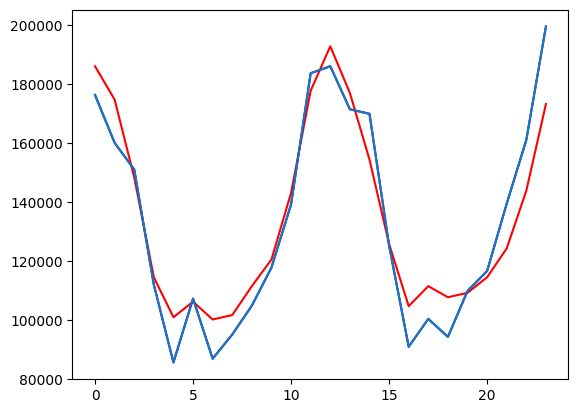

In [1672]:
plt.plot(model.scaler.inverse_transform(prediction).reshape(-1), c='r')
plt.plot(batch_data.future_target_cdf.reshape(-1), c='b')
plt.plot(model.scaler.inverse_transform(future_target_cdf).reshape(-1))

In [1673]:
batch_data.past_target_cdf.shape

torch.Size([1, 84, 1])

In [1674]:
# context_length = data_manager.context_length
# prediction_length = data_manager.prediction_length
# past_range = range(0, context_length)
# future_range = range(context_length, context_length + prediction_length)
# full_range = range(0, context_length + prediction_length)
#
# for i in range(min(10, forecaster.target_dim)):
#     target = torch.cat([past_target_cdf[batch_idx, -context_length:, i], future_target_cdf[batch_idx, :, i]])
#     plt.figure(figsize=(10, 2))
#     plt.plot(full_range, target)
#     plt.plot(future_range, prediction[:, i])

In [1675]:
trainer.test(model=model, datamodule=data_module);

/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

the scaler was fitted
inputs:
torch.Size([1, 72, 200])
tensor([[177.,  83.,  34.,   7.,  15.,   6.,   1.,   8.,  34.,  57.,  85., 173.,
         187.,  95.,  46.,  11.,  28.,  12.,  10.,  25.,  36.,  62.,  79., 197.,
         197., 104.,  59.,  14.,  28.,  16.,   9.,  31.,  31.,  64.,  78., 193.,
         200.,  99.,  56.,  14.,  29.,  15.,  11.,  21.,  49.,  47.,  76., 166.,
         176.,  94.,  53.,  13.,  28.,   8.,   2.,  25.,  31.,  58.,  76., 176.,
         193., 101.,  57.,  19.,  36.,  15.,  11.,  22.,  54.,  64.,  76., 174.]])
torch.Size([1, 24, 200])
forecast : tensor([[196, 111,  68,  34,  37,  24,  23,  32,  49,  65,  87, 188, 199, 117,
          76,  44,  39,  26,  25,  38,  51,  67,  88, 197]])
the scaler was fitted
inputs:
torch.Size([1, 72, 200])
tensor([[150., 148., 111.,  49.,  33.,  40.,  20.,  39.,  45.,  81., 108., 179.,
         173., 136.,  97.,  40.,  27.,  40.,  46.,  44.,  62.,  73.,  99., 140.,
         200., 145., 100.,  52.,  24.,  46.,  29.,  43.,  46.,  

/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


torch.Size([1, 24, 200])
forecast : tensor([[155, 139, 105,  59,  41,  48,  41,  42,  55,  68,  99, 143, 163, 144,
         113,  66,  45,  55,  50,  51,  58,  71,  99, 138]])
the scaler was fitted
inputs:
torch.Size([1, 72, 200])
tensor([[107.,  79., 136., 129., 112., 116., 120., 106., 102., 166., 142., 109.,
         109.,  94., 143., 147., 132., 144., 141., 120., 118., 176., 160., 141.,
         112., 113., 156., 159., 140., 149., 145., 130.,  94., 123., 126., 124.,
         128.,  94., 160., 158., 138., 145., 143., 126., 120., 180., 164., 135.,
         136., 100., 116.,   9.,   1.,  22.,  77., 112., 119., 150., 137., 116.,
         104., 115., 146., 152., 136., 159., 166., 142., 141., 200., 177., 151.]])
torch.Size([1, 24, 200])
forecast : tensor([[142, 143, 161, 160, 150, 152, 156, 144, 142, 178, 166, 151, 138, 137,
         160, 158, 150, 151, 154, 144, 144, 172, 169, 156]])
the scaler was fitted
inputs:
torch.Size([1, 72, 200])
tensor([[107.,  82., 139., 118., 103.,  82., 112.,

In [1676]:
future_target_cdf.shape

torch.Size([1, 24, 1])

In [1677]:
# trainer.test(model=model, dataloaders=train_dataloader);